<img src="nyc_logo.png" style="height:110px">
<center><h1><font color='#FDB515'>Dataxi Science</center></font></h1></center>
<center><h2>A Data Science approach to analyze and predict Medallion Taxi Demand</h2></center>
<center> <h4> Author: Jishu Basak </h4></center>  

In [2]:
%%html
<link href='https://fonts.googleapis.com/css?family=Roboto' rel='stylesheet'>
<style>
body {
    font-family: 'Roboto', 'Helvetica', sans-serif; 
    font-size: 16px;
}
</style>

In [137]:
#Essential Imports
import pandas as pd
import numpy as np
import random
import itertools
import math
import os
import time

#Visualization Libraries
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as pyo

# Set notebook mode to work in offline
pyo.init_notebook_mode()
%matplotlib inline

#Google Big Query
from google.cloud import bigquery
import google.cloud.bigquery.magics
import google.auth
from pandas.io import gbq
import pandas_gbq

#Database libraries
import sqlite3
from sqlalchemy import create_engine
from utils import Clockplot,get_lat_lon,plt_clock,PlotSLD,get_boundaries,Regionmap,Zonemap

#Parallel Computing
import dask.array as da
from dask.distributed import Client
import dask.dataframe as dd

#ML
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark
import pyspark.sql.functions as f
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor



from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
<input type="submit" id="toggleButton" value="Show Code"></form>''')


<h1><font color='#FDB515'>Executive Summary</font></h1>

<div align='justify'>There are roughly 200 million taxi rides in New York City each year. Exploiting an understanding of taxi supply and demand could increase the efficiency of the city’s taxi system. In the New York city, people use taxi, specifically 'Yellow Taxi' in a frequency much higher than any other cities of US. Instead of booking a taxi by phone one day ahead of time, New York taxi drivers pick up passengers on street. The ability to predict taxi ridership could present valuable insights to city planners and taxi dispatchers in answering questions such as how to position cabs where they are most needed, how many taxis to dispatch, and how ridership varies over time.This mini project focuses on predicting the number of yellow taxi pickups given a one-hour time window and a location within New York City.
<br>
<ul>
    <li>After Data Analysis, I found out that Manhattan(Borough), JFK Airport and LaGuardia Airport are the most demanding place when it comes to both, Passenger Count and Total amount.</li>
    <li> Evenings are the busiest and Mornings, specially around 5AM are silent when it comes to demand.</li>
    <li> Gradient Boosting Regressor out performs in predicting Passenger Demand and Total Gross revenue demand based on Date/Time and Pickup location.</li>
</div>

<h1><font color='#FDB515'> Table of Contents</font></h1>

    A. Introduction
    B. Problem Statement
    C. Methodology
        1. Data Extraction and Storage
        2. Data Cleanup and Feature Engineering
        4. Exploratory Data Analysis
        5. Feature Engineering
        6. Modelling
    D. Conclusions and Future Work

<h1><font color='#FDB515'>A. Introduction</font></h1>

<div align='justify'> In New York City, taxicabs come in two varieties: yellow and green; they are widely recognizable symbols of the city. Taxis painted yellow (medallion taxis) are able to pick up passengers anywhere in the five boroughs.Taxicabs are operated by private companies and licensed by the New York City Taxi and Limousine Commission (TLC)
<br><br>
The New York City Taxi and Limousine Commission (TLC), created in 1971, is the agency responsible for licensing and regulating New York City's Medallion (Yellow) taxi cabs, for-hire vehicles (community-based liveries, black cars and luxury limousines), commuter vans, and paratransit vehicles. The Commission's Board consists of nine members, eight of whom are unsalaried Commissioners. The salaried Chair/ Commissioner presides over regularly scheduled public commission meetings and is the head of the agency, which maintains a staff of approximately 600 TLC employees.

Over 200,000 TLC licensees complete approximately 1,000,000 trips each day. To operate for hire, drivers must first undergo a background check, have a safe driving record, and complete 24 hours of driver training. TLC-licensed vehicles are inspected for safety and emissions at TLC's Woodside Inspection Facility.
</div>

<h1><font color='#FDB515'>B. Problem Statement</font></h1>

<div align='justify'> There are roughly 200 million taxi rides in New York City each year. Exploiting an understanding of taxi supply and demand could increase the efficiency of the city's taxi system. This mini project focuses on predicting the passenger demand and total gross revenue demand given a the given time (one-hour time window) and a location within New York City. In general this project aims to answer how can Data Science address the pitfall in demand of Medallion Taxi in New York City.</div>

<h1><font color='#FDB515'>C. Methodology</font></h1>

The high-level workflow for NYC Yellow Taxi Demand prediction and analysis is as follows:

1. Data Description, Extraction and Storage
2. Data Cleaning and Feature Engineering
4. Data Analysis
5. Feature Engineering
6. Modelling

Each step of the workflow will be discussed in detail in the succeeding sections.

<h3><font color='#C9082A'> 1. Data Description, Extraction and Storage

<div align='justify'> The datasets for this project were extracted using BigQuery from Google based Cloud Data Warehouse. It contains most of the large publicly accessible datasets. The official TLC trip record dataset contains data for over 1.1 billion taxi trips from January 2009 through June 2015, covering both yellow and green taxis. Each individual trip record contains precise location coordinates for where the trip started and ended, timestamps for when the trip started and ended, plus a few other variables including fare amount, payment method, and distance traveled. 
    
<br>

For this project, I focused my study on <b>Yellow Trips Dataset</b>, for year <b>2017</b> capturing first all <b>12 months</b>. All the fields were queried and saved in local database using Google BigQuery API client library for Python.
<br>  
<h4><font color='#17408B'> Data Dictionary </font></h4>
    
The original dataset has 17 columns, namely, <br>
<img src="data_des.PNG" style="height:100%">

</div>

In [ ]:
#Setting Credentials for accessing google API
google.cloud.bigquery.magics.context.use_bqstorage_api = True

credential_path = r"C:\Users\Dell-pc\Desktop\Thinking Machines\nyctlc\mykey.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

In [ ]:
# Making clients.
client = bigquery.Client.from_service_account_json("mykey.json")
project_id = "thinking-machines-exam-285522"

<h3><font color='#C9082A'> 2. Data Cleaning and Feature Engineering </font></h3>
<div align='justify'> 
    
<h4><font color='#17408B'> Data Cleaning </font></h4>
<br>
Minimal Data Cleaning was done as the dataset was already sanitized. Removed rows that had year other than 2017 and months that were not between January and June inclusive. 
<br>
<h4><font color='#17408B'> Feature Extraction </font></h4>
<br>
Columns with Date and Time datatype were used to extract features such as Hour, Date, Weekday and Month
</div>

In [ ]:
query = """
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`
"""
df = gbq.read_gbq(query, project_id=project_id, private_key='mykey.json')
df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
df.index += j
df.to_sql('table_record', nyc_database, if_exists='append')
df.to_csv('nyc_database.csv')

In [134]:
#Connecting to Preprocessed Dataset(After performing Data Extraction, Cleaning and Feature Engineering)
nyc_database = sqlite3.connect('nyc_database.db')

<h3><font color='#C9082A'> 3. Data Analysis </font></h3>

<h4><font color='#17408B'> Location Data </font></h4><br>
After merging the Taxi Zones with the shapefiles for NYC, we can now visualize Taxi zones and Boroughs in NYC.

In [4]:
sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough     longitude       latitude  
0            EWR  9.366817e+05  190522.130278  
1         Queens  1.033536e+06  161853.982300  
2          Bronx  1.027136e+06  254730.010849  
3      Manhattan  9.904240e+05  203100.040432  
4  Staten Island  9.321332e+05  139954.541936

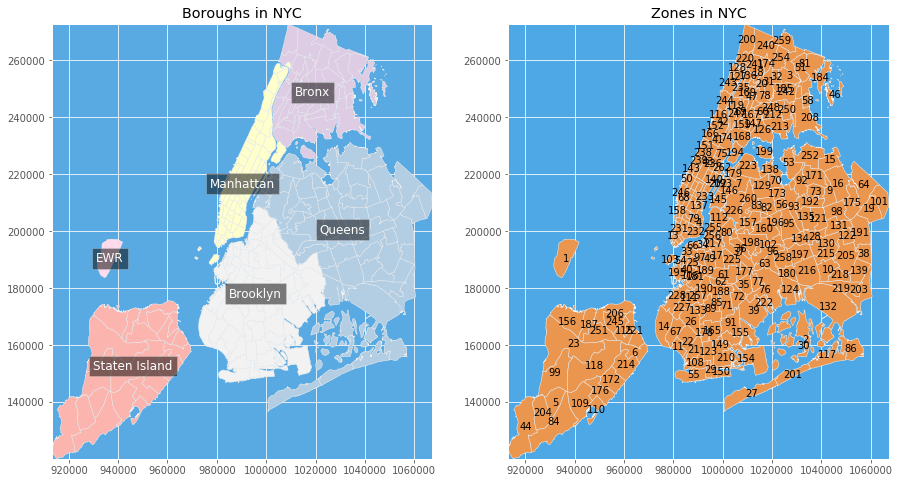

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
Regionmap(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
Zonemap(ax, sf)

#### Analysis 1: Taxi Demand based on Region/Zone: Pick Up vs Drop Off

In [5]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount,sum(total_amount) as Amount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount, sum(total_amount) as Amount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_database)

With the selected data, we want to obtain the zones with most pickups and drop-offs.

In [6]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum','Amount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")
df_q1['Amount'] = df_q1['Amount']/1000

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)
PUmoney = dict(zip(df_q1['LocationID'].tolist(), df_q1['Amount'].tolist()))
PUMtop3 = df_q1.sort_values(by=['Amount'], ascending=False).set_index("LocationID").head(3)

<div align='justify'>
In the tables below, we can see that in the first half of 2017,

<ul>
    <li>The top 3 pickup zones are Upper East Side South, Midtown Center, and Upper East Side North, which are all in Manhattan.</li>
    <li>The top 3 drop-off zones are also Upper East Side South, Midtown Center, and Upper East Side North.</li>
</ul>
</div>

In [12]:
PUtop3

PUcount    DOcount        Amount  TOTALcount  \
LocationID                                                   
237         2231822.0  1954564.0  49471.409061   4186386.0   
161         2103461.0  2051106.0  59789.562801   4154567.0   
236         2040795.0  2110900.0  50181.642601   4151695.0   

                             zone    borough  
LocationID                                    
237         Upper East Side South  Manhattan  
161                Midtown Center  Manhattan  
236         Upper East Side North  Manhattan

In [13]:
DOtop3

PUcount    DOcount        Amount  TOTALcount  \
LocationID                                                   
236         2040795.0  2110900.0  50181.642601   4151695.0   
161         2103461.0  2051106.0  59789.562801   4154567.0   
237         2231822.0  1954564.0  49471.409061   4186386.0   

                             zone    borough  
LocationID                                    
236         Upper East Side North  Manhattan  
161                Midtown Center  Manhattan  
237         Upper East Side South  Manhattan

In [14]:
PUMtop3

PUcount    DOcount         Amount  TOTALcount  \
LocationID                                                    
132         1280607.0   453568.0  100239.260780   1734175.0   
138         1513397.0   593695.0   91238.814670   2107092.0   
161         2103461.0  2051106.0   59789.562801   4154567.0   

                         zone    borough  
LocationID                                
132               JFK Airport     Queens  
138         LaGuardia Airport     Queens  
161            Midtown Center  Manhattan

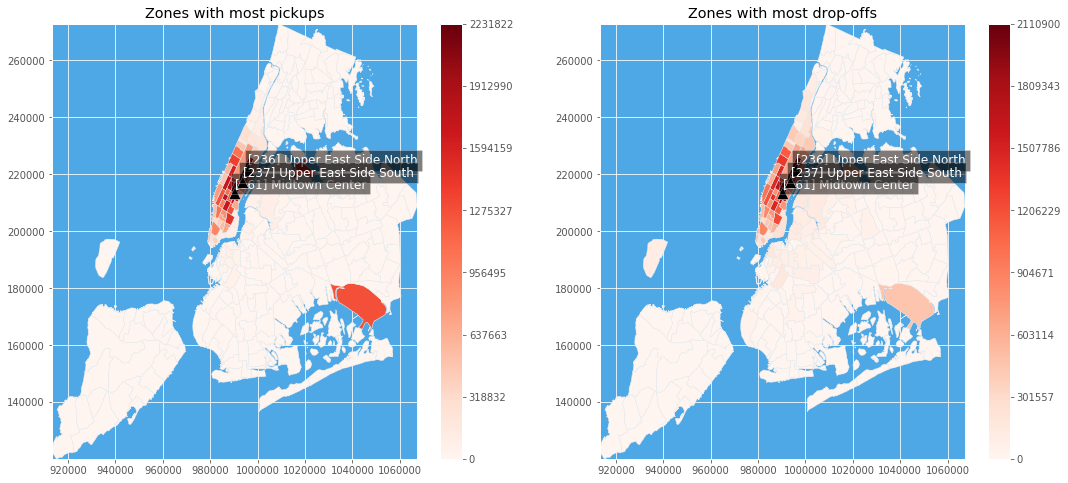

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
Zonemap(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
Zonemap(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

<div align='justify'>Note that in the figure above, we can see that despite the top 3 pickup/dropoff zones, many other zones in <font color='red'>Manhattan</font> are also popular. By the way, the zone in the lower-right part of the map, which is <font color='red'>JFK Airport</font>, is the most popular pickup/dropoff zone in New York City excluding zones in <font color='red'>Manhattan</font>.
</div>

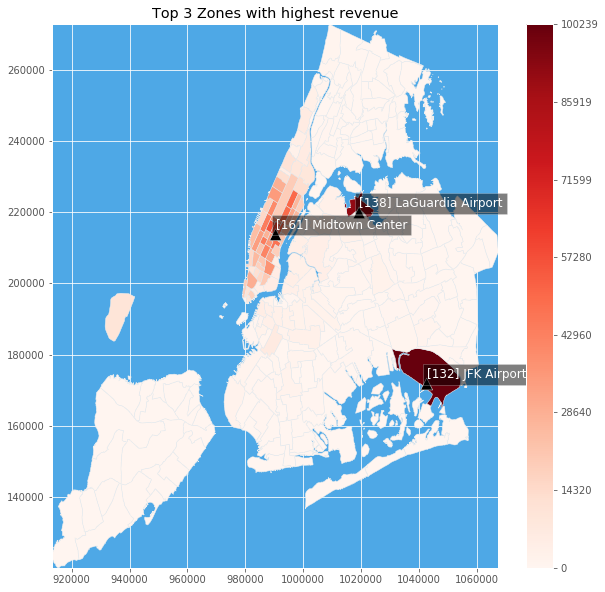

In [16]:
plt.rcParams["figure.figsize"] = (10,10)
ax = plt.subplot(1, 1, 1)
ax.set_title("Top 3 Zones with highest revenue")
Zonemap(ax, sf, heat=PUmoney, text=PUMtop3.index.tolist())

It is evident that Yellow Taxis by far earn the most if they pickup their customers from the most popular Airports in NYC. Note that Midtown Center is also among the top 3, which is obvious as Midtown Manhattan is the world largest business district. We can also observe that the high grossing zones are indeed located in Manhattan. 

Next, we investigate boroughs with most pickups and drop-offs. In the tables below, we can see that <font color='red'>Manhattan</font> is obviously the most popular borough and <font color='red'>Staten Island</font> is the least popular borough. <font color='red'>Queens</font> and <font color='red'>Brooklyn</font> are also popular, although their pickup/droppoff count is less than 10% of <font color='red'>Manhattan's.

In [17]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
df_q1_region

borough     PUcount     DOcount  TOTALcount
3      Manhattan  48959783.0  47740306.0  96700089.0
4         Queens   3364216.0   2619242.0   5983458.0
1       Brooklyn    683135.0   2280186.0   2963321.0
0          Bronx     55810.0    338928.0    394738.0
2            EWR      3854.0     99708.0    103562.0
5  Staten Island       815.0     11250.0     12065.0

In [18]:
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

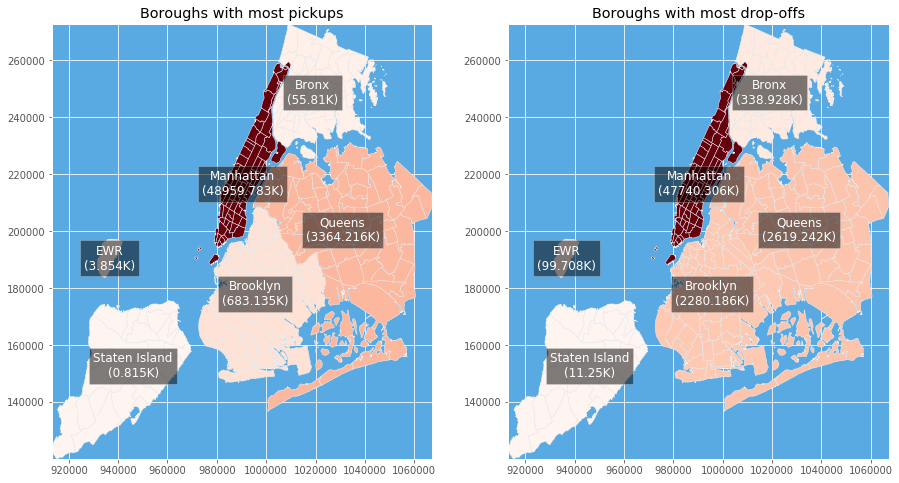

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
Regionmap(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
Regionmap(ax, sf, heat = DOcount)

In the figure above, it is noticed that in the first half of 2017, there are more pickups in Queens than in Brooklyn while there are similar number of drop-offs in both Queens and Brooklyn. 
Yet, when it comes to the demand, Manhattan beats all the Boroughs and for the right reasons. There are more outlets, more corporates, highend bars to name a few, which not only makes it more popular, reflected by its exorbitantly high housing price in whole New York city.

Thus if I owe a Yellow Cab Taxi company, I would definitely want to start operating in Manhattan compared to other Boroughs. But since Manhattan is populated and the competetion is high, my second option as a business man should be Queens, followed by Brooklyn

#### Analysis 2: Taxi Demand based on Time: Pick Up vs Drop Off
Lets query the database for the exact data that we would need 

In [139]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

From the selected data, we arrange and show the visualization of the information we need.

In [136]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_q2['time'], y=df_q2['Pick-ups'], name='Pick Up',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=df_q2['time'], y=df_q2['Drop-offs'], name='Drop Offs',
                         line=dict(color='royalblue', width=4)))
fig.update_layout(title='Pick-Ups vs Drop-Offs',
                   xaxis_title='Time in Hours(24-Hour clock)',
                   yaxis_title='Count')
fig.show()

<div align='justify'>Based on the visuals on NYC Yellow Taxi records from 2017 January to 2017 June, we can observe that:

<ul>
    
<li>The peak hours are around <font color='red'> 6PM ~ 7PM. </font></li>
<li> The off-peak hours are around <font color='red'> 5AM.</font></li>
</ul>
</div>

#### Analysis 3: Taxi Demand based on Distance: Short Distance Trips vs Long Distance Trips
Before we start, we should define what short and long distance trips are at first. 


To get a closer look at the distribution of trip distance, we select the trip_distance column values and print out its summary statistics.

In [25]:
df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record', nyc_database)
df_dist['trip_distance'].describe()

count    5.392574e+07
mean     2.900861e+00
std      2.607412e+01
min      0.000000e+00
25%      9.600000e-01
50%      1.600000e+00
75%      3.000000e+00
max      1.894838e+05
Name: trip_distance, dtype: float64

The distrubution of trip_distance is extremely right skewed, which is shown in the figure below.

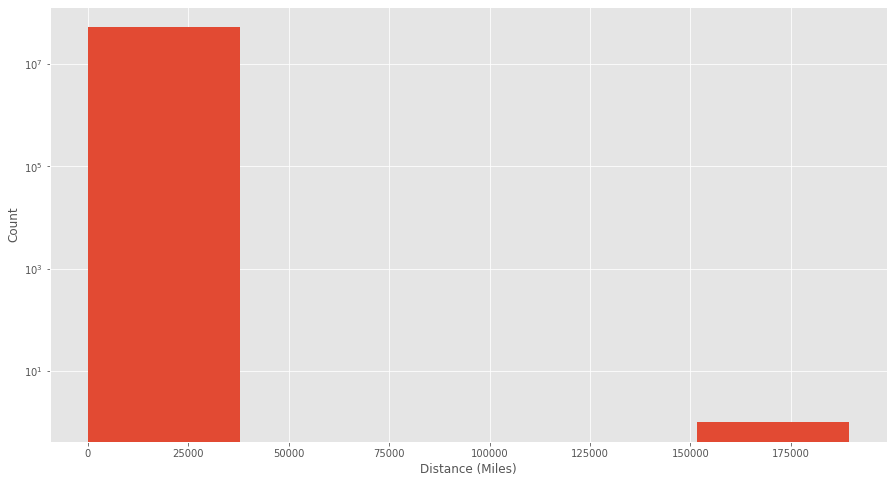

In [26]:
ax = df_dist['trip_distance'].hist(bins=5, figsize=(15,8))
ax.set_yscale('log')
ax.set_xlabel("Distance (Miles)")
ax.set_ylabel("Count")
plt.show()

The fact that it takes about 30 miles(approximate perimeter of New York city) to drive across the whole New York City, I decided to use 30 as the number to split the trips into short or long distance trips.

In [27]:
df_q3_short = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                 WHERE trip_distance < 30', nyc_database)
df_q3_long = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                WHERE trip_distance >= 30 ', nyc_database)
print("Short Trips: {} records in total.\nLong Trips: {} records in total."\
     .format(df_q3_short.values[0][0], df_q3_long.values[0][0]))

Short Trips: 53903852 records in total.
Long Trips: 21883 records in total.


Based on instincts, trips which are longer in nature should have different Pickup/Dropoff time compared to shorter trips. To validate our assumption, we first select temporal information from our database.

In [28]:
df_q3_short = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)
df_q3_long = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

Lets visualize them

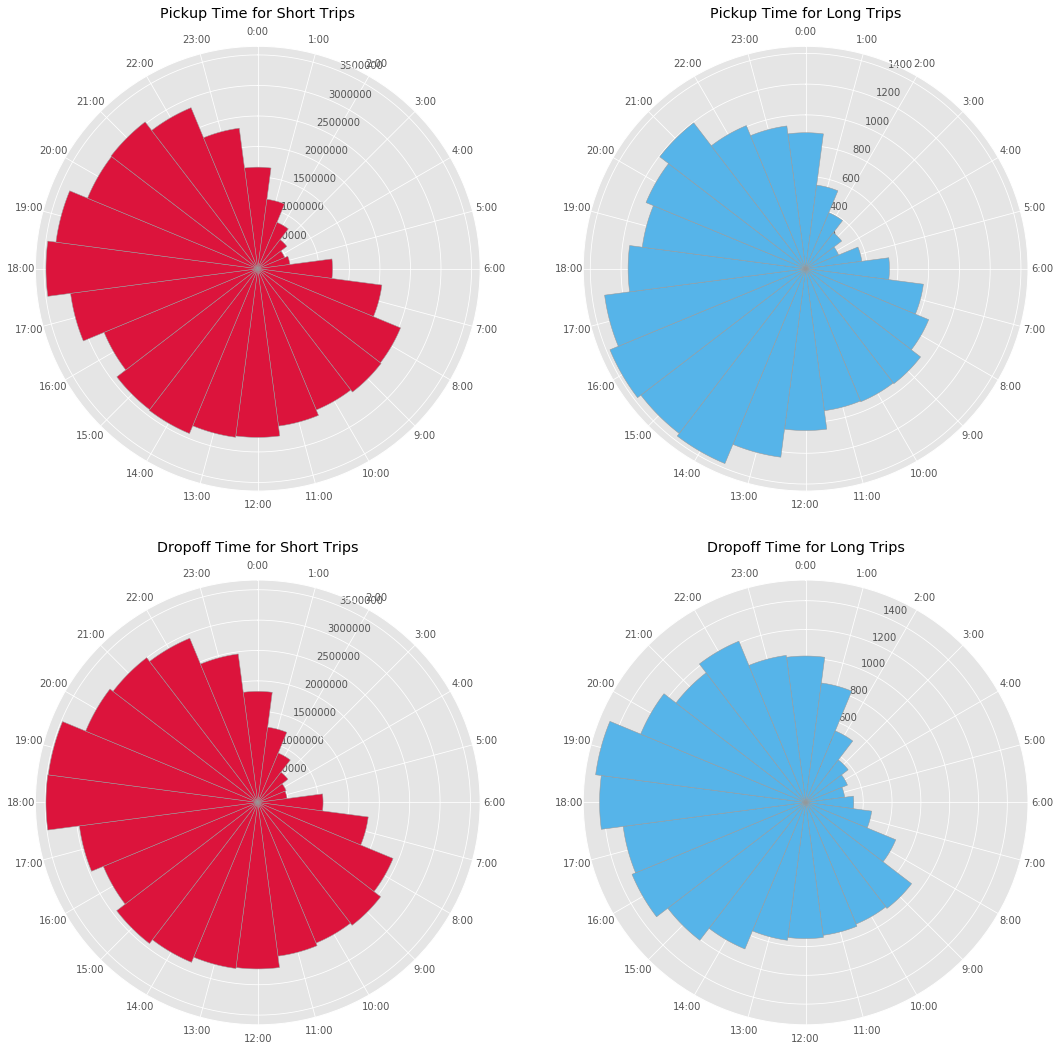

In [29]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})

df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")

Clockplot()

<div align='justify'> 
    
Based on the figure shown above, we can observe that

For short trips,
<ul>
    <li>The peak hours of pickups are from <font color='red'>6PM to 10PM.</font></li>
    <li>The peak hours of dropoffs are also from <font color='red'>6PM to 10PM.</font></li>

</ul>
<br>
For long trips ( > 30 miles),
<ul>
    <li>The peak hours of pickups are from <font color='red'> 1PM to 4PM.</font></li>
    <li> The peak hours of dropoffs are from <font color='red'>3PM to midnight.</font></li>
</ul>
<br>    
The off-peak hours are similar for both short trips and long trips.
With these observations, it can be guesed that

Short trips are mainly contributed by people having dinner and hanging out at night.
Long trips ( > 30 miles) are contributed by travelers taking an arrival or a departure.
    
<br>
In the next steps, I will try to summarize the spatial attributes of short trips and long trips to examine my instincts. Here we extract pickup/dropoff locations and their counts from database by grouping the counts by each ('pickup zone', 'dropoff zone') pair.
</div>

In [30]:
df_q3_short = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)
df_q3_long = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)

After extracting data from database, we then arrange the information and show the top 3 <font color='red'>('pickup zone', 'dropoff zone')</font> pair for both short trips and long trips.

In [31]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PULocationID", "DOLocationID"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips"})
df_q3 = df_q3.merge(df_loc[["LocationID", "zone"]], left_on="PULocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"pickup zone"}) \
             .merge(df_loc[["LocationID", "zone"]], left_on="DOLocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"dropoff zone"})

<div align='justify'>
In the tables below, we can see that

<ol>
    <li><b>The top 3 routes for short trips</b> are all in the most outgoing area in Manhattan, which are crowded with restaurants and entertainment venues.</li>
    <li><b>The top 3 routes for long trips ( > 30 miles)</b> are routes that drive from one airport zone to another.</li></ol>
The second popular route is a special case that passengers are picked up from and also dropped-off at JFK Airport, which may be some kind of city tours of the tranfer during their waiting time between the connecting flights.

These findings support our guesses that long trips are for traveling and that short trips are for casual eating or for entertainment purpose.
</div>

In [32]:
shortTrip_top3 = df_q3.sort_values(by="short trips", ascending=False).head(3)
shortTrip_top3[['pickup zone', 'dropoff zone', 'short trips']]

pickup zone           dropoff zone  short trips
803  Upper East Side North  Upper East Side North       276809
813  Upper East Side South  Upper East Side South       249833
207  Upper East Side South           Midtown East       139087

In [33]:
longTrip_top3 = df_q3.sort_values(by="long trips", ascending=False).head(3)
longTrip_top3[['pickup zone', 'dropoff zone', 'long trips']]

pickup zone    dropoff zone  long trips
24         JFK Airport  Newark Airport        1473
112        JFK Airport     JFK Airport         683
26   LaGuardia Airport  Newark Airport         487

On the other hand, we can also observe the popular zones for short and long trips on map. By aggregating the pickup/dropoff trip count of each zone, we then show the popular pickup/drop-off zones for short trips and long trips.

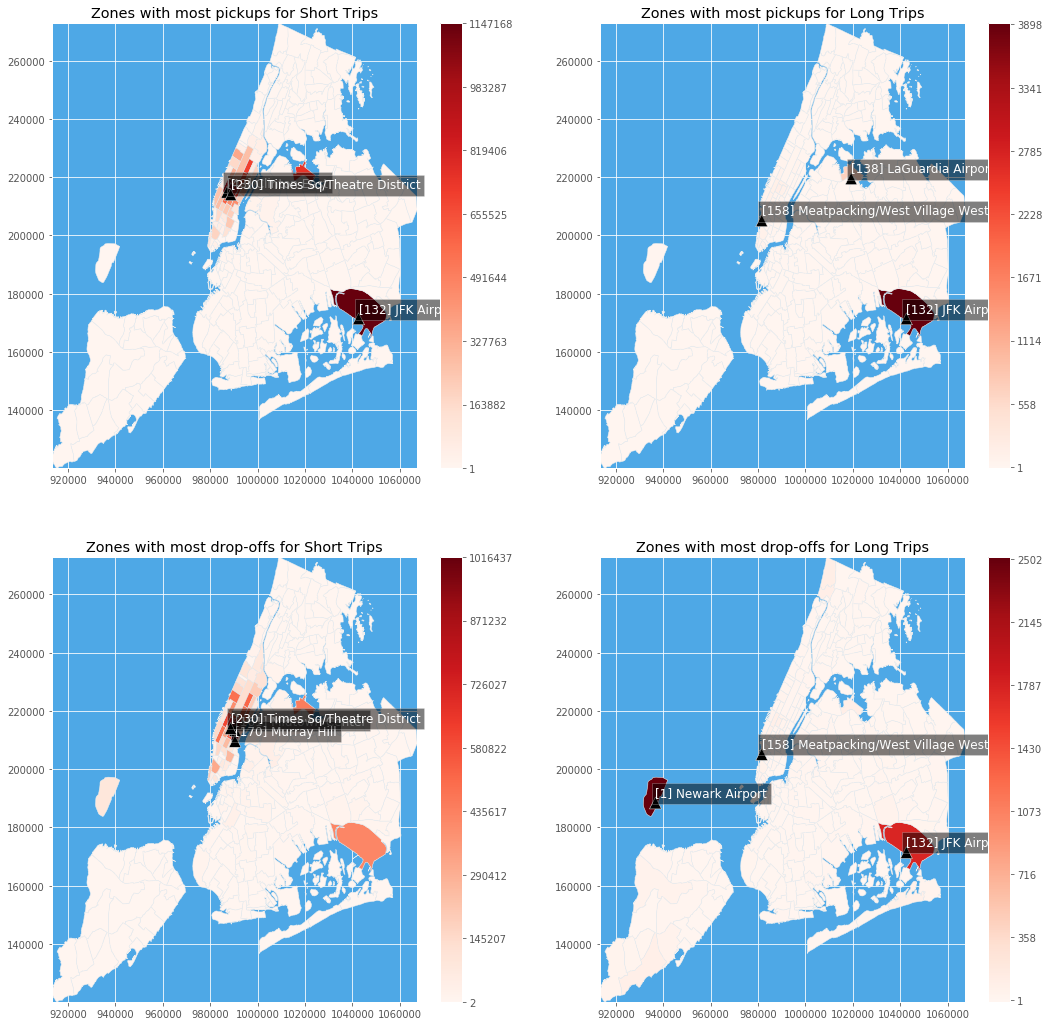

In [34]:
df_q3_PU = df_q3.groupby("PULocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
PUtop3_short = df_q3_PU.sort_values(by=['short trips'], ascending=False).set_index("PULocationID").head(3)
PUtop3_long = df_q3_PU.sort_values(by=['long trips'], ascending=False).set_index("PULocationID").head(3)
PUcount_short = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['short trips'].tolist()))
PUcount_long = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['long trips'].tolist()))

df_q3_DO = df_q3.groupby("DOLocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
DOtop3_short = df_q3_DO.sort_values(by=['short trips'], ascending=False).set_index("DOLocationID").head(3)
DOtop3_long = df_q3_DO.sort_values(by=['long trips'], ascending=False).set_index("DOLocationID").head(3)
DOcount_short = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['short trips'].tolist()))
DOcount_long = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['long trips'].tolist()))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
Zonemap(ax, sf, heat=PUcount_short, text=PUtop3_short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
Zonemap(ax, sf, heat=PUcount_long, text=PUtop3_long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
Zonemap(ax, sf, heat=DOcount_short, text=DOtop3_short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
Zonemap(ax, sf, heat=DOcount_long, text=DOtop3_long.index.tolist())

<div align='justify'>From the figure above, we can find something interesting:
    <ol>
        <li>Surprisingly, JFK Airport is the most popular pickup zone for short trips.</li>
            More specifically, in a year, there are about 1 million taxis taken from JFK Airport (about 5700 trips per day) and drive no more than 30 miles to arrive their destination.<br>
            These passengers may contain foreign travelers or locals who just came back from abroad.
        <li>There are more drop-offs at JFK Airport than Newark Airport in short trips.</li>
        <li>There are more drop-offs at Newark Airport than JFK Airport in long trips.</li>
        <li>For long trips, JFK Airport and LaGuardia Airport are the most popular pickup zones.</li>
    </ol>
</div>

Lastly, we compare short trips and long trips in some other aspects.

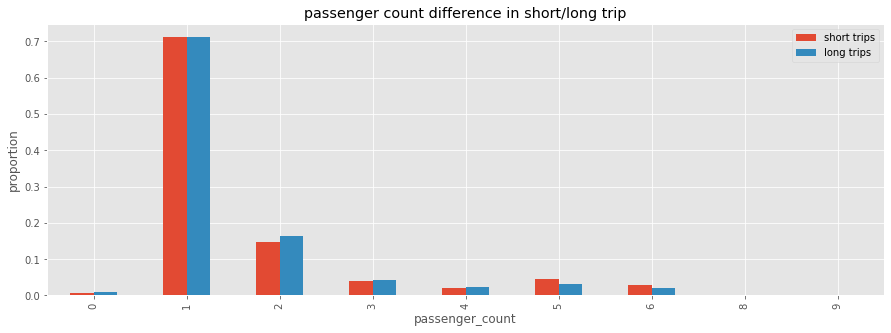

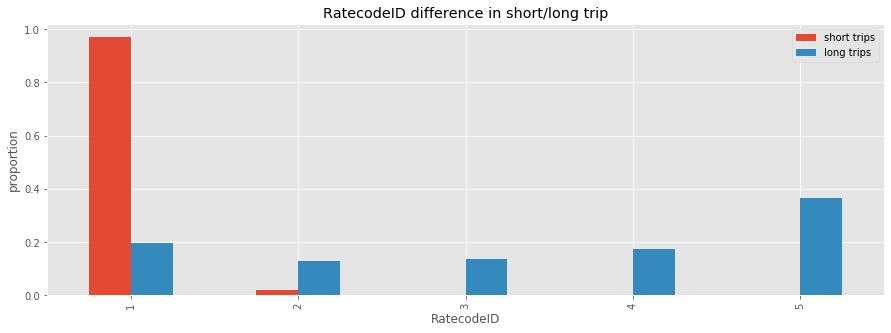

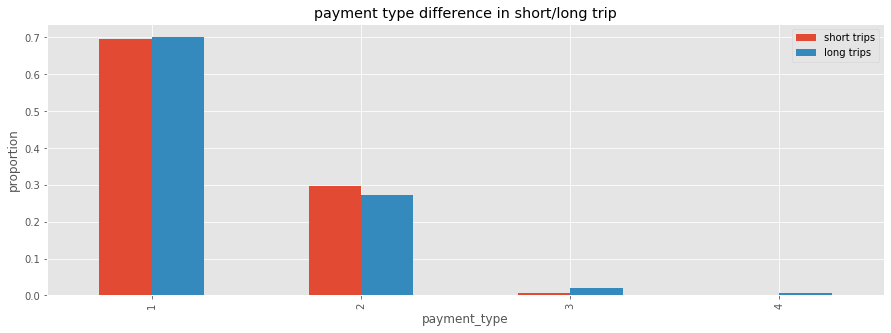

In [35]:
for attr in ["passenger_count", "RatecodeID", "payment_type"]:
    PlotSLD(attr, rpr="proportion", kind='bar')

- Unexpectedly, the distribution of passenger count is nearly the same for short trips and long trips. 
- It can be seen that 40 percent of long trips use Negotiated fare and another 40 percent of long trips use JFK, Newark, or Nassau or Westchester while less than 5 percent of short trips use any of them.
- Passengers of long trips paid a little more frequent in credit card and a little less frequent in cash comparing to that of short trips.

<h3><font color='#C9082A'> 4. Feature Engineering </font><h3>

<div align='justify'>
    <h6>Below is a list of feature templates we use to extract features from each data point:</h6>
<br>
    <ol>
        <li>Grouping by Features. In the next step, which is Modelling, we will be creating 2 models, viz, <b> Passenger Demand Predictor</b> and <b> Gross Revenue Demand Predictor </b>, where the input features are Date & Time and Pickup Location. The intuition is to create a decision support tool for city planner or perhaps taxi dispatchers, where based on solemly time and location, they can take decision that can perhaps generate profits for taxi companies, provide some accessibility to the passengers developed by the city planners, control surge to name a few. Thus the dataset is grouped by Hour, Month Day, Total Amount, Passenger Count and Pickup Location, where for two different scenarios, Total Amount and Passenger Count are aggregated in the dataset. </li>
        <li> String Indexing. Using String Indexer function provided by pySpark ML library, we will convert all the string columns to numeric columns, specifically Date, Amount and Passenger Count in our scenario. </li>
        <li> One Hot Encoding. To improve the effectiveness and minimize the error, we shall One Hot Encode the Pickup Location, which are essentially Zones in 5 Borough, depicted by a unique number that ranges from 1 to 255. </li>
        <li> Vector Assembler. VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like Gradient Boosting and Decision trees. VectorAssembler accepts the following input column types: all numeric types, boolean type, and vector type. In each row, the values of the input columns will be concatenated into a vector in the specified order.</li> 
    </ol>
<br><br>
    
In summary, this following picture describes the process flow in Feature Engineering section:
<img src='Feature_eng.png' width='100%'>
</div>


##### Grouping by features from the existing database
Take note that for the case of model development, we shall be using data of all the months for year 2017.

In [2]:
SparkContext.setSystemProperty('spark.executor.memory', '8g')
sc = SparkContext("local", "App Name")
spark = SparkSession(sc)

In [167]:
df_yellow_temp = spark.read.csv('nyc_database.csv',header=True)

In [168]:
df_yellow_temp = df_yellow_temp.cache()

In [ ]:
df_yellow_temp.rdd.getNumPartitions()

In [171]:
df_yellow_temp = df_yellow_temp.select(df_yellow_temp.passenger_count,
                               df_yellow_temp.trip_distance,        
                              df_yellow_temp.PULocationID,
                              df_yellow_temp.DOLocationID,
                              df_yellow_temp.total_amount,
                              year(df_yellow_temp.tpep_pickup_datetime).alias('Year'), 
                              month(df_yellow_temp.tpep_pickup_datetime).alias('Month'), 
                              dayofmonth(df_yellow_temp.tpep_pickup_datetime).alias('Day'), 
                              hour(df_yellow_temp.tpep_pickup_datetime).alias('Hour'))
df_yellow_temp.show()

+---------------+-------------+------------+------------+------------+----+-----+---+----+
|passenger_count|trip_distance|PULocationID|DOLocationID|total_amount|Year|Month|Day|Hour|
+---------------+-------------+------------+------------+------------+----+-----+---+----+
|              1|          .40|         161|         161|         4.8|2017|    9|  1|   0|
|              2|          .90|         164|         234|        7.55|2017|    9|  1|   0|
|              1|          .52|         193|         193|         5.3|2017|    9|  1|   0|
|              1|         1.50|         246|          50|         7.3|2017|    9|  1|   0|
|              1|         1.30|         143|         143|        10.8|2017|    9|  1|   0|
|              1|         1.50|          50|         143|        11.3|2017|    9|  1|   0|
|              1|         1.60|         163|         186|         9.3|2017|    9|  1|   0|
|              1|          .70|         163|         162|         6.3|2017|    9|  1|   0|

In [172]:
df_yellow_temp = df_yellow_temp.cache()

In [90]:
# null values in each column
data_agg = df_yellow_temp.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df_yellow_temp.columns])
data_agg.show()

In [86]:
df_pass = df_yellow_temp.withColumn('passenger_count', df_yellow_temp.passenger_count.cast('float')).groupby('Month','Day','Hour','PULocationID').sum('passenger_count')

In [87]:
df_pass = df_pass.cache()

In [247]:
df_amount = df_yellow_temp.withColumn('total_amount', df_yellow_temp.total_amount.cast('float')).groupby('Month','Day','Hour','PULocationID').sum('total_amount')

In [248]:
df_amount = df_amount.cache()

The Dataset has no missing values. After grouping by, we now have two different dataframes:
- Passenger Dataframe: An sum based aggregation on Passenger counts by grouping Features such as Hour, Day, Month and PickupLocationID
- Amount Dataframe: An sum based aggregation on Total amount in USD by grouping Features such as Hour, Day, Month and PickupLocationID

Note: String Indexer, One Hot Encoder and Vector Assembly operations will be implemented in the <b> Modelling </b> section

<h3><font color='#C9082A'> 5. Modelling </font></h3>
    
In this section, I will train different Machine Learning Regression algorithms to address two challenges, which are, <b> Prediction of Passenger Demand based on Time and Location</b> and <b> Prediction of Gross Revenue based on Time and Location</b>. 

The following image depicts the general flow of our pipeline:

<br>
<img src='model_implementation.png'>
<br><br>
<b> <center> Machine Learning Problem Type: Supervised Learning - Regression </center></b>

As mentioned in the figure, after Feature Engineering, the intuition is to train the data for all the Regressors mentioned, with <b>Train/Test split of 70/30</b> and <b>Cross Validation folds of 30%</b>. For Hyperparameter Optimization, I will implement Grid Search. The pySpark version of Sci-kit Learn's GridSearchCV is implemented by ParamGrid. For the Evaluation metrics, I will use RMSE and R² Score to compare and contrast the robust models among the four. Due to linear nature of the input and the output variables, R² Score is a valid evaluation metric in this scenario.

<br>
The following figure depicts the overall pipeline of the Modelling Section.
<img src='dst.png'>
    
### 5.1 Model 1 - Predicting Taxi demand: Total Passenger
<img src='model_1.png'>

<b>Independent Variables / Features / Input : </b>
- Hour
- Day
- Month
- Pickup Location

<b>Dependent Variable / Target / Output : </b>
- Passenger Count

##### String Indexing

StringIndexer encodes a string column of labels to a column of label indices. StringIndexer can encode multiple columns.

The input variables or Features or Independent Variables to this model are Hour, Day, Month and Pickup Location whereas the Output or Target Variable or the Dependent Variable is Passenger Count. Since they are all numeric in nature, using String Indexer, they will be converted from String type to Numeric type.


In [ ]:
# create object of StringIndexer class and specify input and output column
df_month = StringIndexer(inputCol='Month',outputCol='pass_month')
df_day = StringIndexer(inputCol='Day',outputCol='pass_day')
df_hour = StringIndexer(inputCol='Hour',outputCol='pass_hour')
df_puloc = StringIndexer(inputCol='PULocationID',outputCol='pass_pickup')
df_passenger = StringIndexer(inputCol='sum(passenger_count)',outputCol='passenger_count')

# transform the data
df_pass = df_month.fit(df_pass).transform(df_pass)
df_pass = df_day.fit(df_pass).transform(df_pass)
df_pass = df_hour.fit(df_pass).transform(df_pass)
df_pass = df_puloc.fit(df_pass).transform(df_pass)
df_pass = df_passenger.fit(df_pass).transform(df_pass)

# view the transformed data
df_pass.select('pass_month', 'pass_day', 'pass_hour', 'pass_pickup', 'passenger_count').show(10)

##### One Hot Encoding

Categorical data often must be encoded when working with machine learning algorithms.

Specifically:

- That categorical data is defined as variables with a finite set of label values.
- That most machine learning algorithms require numerical input and output variables.
- That an integer and one hot encoding is used to convert categorical data to integer data.

Pickup Location is categorical in nature. Thus OHE will be applied to it

In [ ]:
# create object and specify input and output column
OHE = OneHotEncoderEstimator(inputCols=['pass_pickup'],outputCols=['pass_pickup_OHE'])

# transform the data
df_pass = OHE.fit(df_pass).transform(df_pass)

# view and transform the data
df_pass.select('pass_month', 'pass_day', 'pass_hour', 'pass_pickup_OHE', 'passenger_count').show(10)

##### Vector Assembly
As mentioned earlier in the Feature Engineering section, this step is crucial when implementing Machine Learning in pySpark

In [ ]:
# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['pass_month', 
                                         'pass_day', 
                                         'pass_hour', 
                                         'pass_pickup_OHE'],
                           outputCol='features')
# transform the data
final_data = assembler.transform(df_pass)

# view the transformed vector
final_data = final_data.select(['features', 'passenger_count'])

In the next sub sections, I will be training 4 machine learning algorithms, in my case, Regressors, which are mentioned below:

- Simple Linear Regression
- Decision Tree Regressor
- Gradient Boosting Regressor
- Random Forest Regressor

The implementation of machine learning in pyspark is similar to tensorflow with small modifications. The following picture depicts the flow of code execution:

<img src='model_pyspark.png'>

#### 5.1.1 Linear Regression

Linear regression is a basic and commonly used type of predictive analysis.  The overall idea of regression is to examine two things: 
- Does a set of predictor variables do a good job in predicting an outcome (dependent) variable?  
- Which variables in particular are significant predictors of the outcome variable, and in what way do they–indicated by the magnitude and sign of the beta estimates–impact the outcome variable?  

These regression estimates are used to explain the relationship between one dependent variable and one or more independent variables. 

Parameters Tuned:
- Maximum Iterations(maxIter): Parameter for for maximum number of iterations
- Regularization(regParam): Parameter for regularization
- Elastic Net Param(elasticNetParam): Param for the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 1: Linear regression model                          
start = time.time()
lr = LinearRegression(featuresCol = 'features', 
                      labelCol='passenger_count')

evaluator = RegressionEvaluator(labelCol="passenger_count", predictionCol="prediction", metricName="rmse")
grid = ParamGridBuilder().addGrid(lr.maxIter, [100,200,500]) \
                                .addGrid(lr.regParam, [0,0.3,0.5]) \
                                .addGrid(lr.elasticNetParam, [0.5,1]) \
                                .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, \
                        evaluator=evaluator, numFolds=3)


# fit the pipeline for the training data
model = lr_cv.fit(train_df)
# transform the data
train_df = model.transform(train_df)

end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
lr_1_time = minutes

In [ ]:
lr_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
lr_1_r2_train = rf_evaluator_train.evaluate(train_df)*100
lr_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
lr_1_rmse_train = lr_evaluator_train.evaluate(train_df)

In [ ]:
lr_predictions = model.transform(test_df)
lr_predictions.select("prediction","passenger_count","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
lr_1_r2_test = lr_evaluator.evaluate(lr_predictions)*100
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
lr_1_rmse_test = lr_evaluator.evaluate(lr_predictions)

In [119]:
bestModel = model.bestModel
print('Best Param (regParam): ', bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())


Best Param (regParam):  0.0
Best Param (MaxIter):  100
Best Param (elasticNetParam):  0.5


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/linear_regression/'
model.write().overwrite().save(path)

##### 5.1.2 Decision Tree Regressor
Decision Trees can be summarized with the below bullet points:

- Decision trees are predictive models that use a set of binary rules to calculate a target value.
- Each individual tree is a fairly simple model that has branches, nodes and leaves.

A decision tree is arriving at an estimate by asking a series of questions to the data, each question narrowing our possible values until the model get confident enough to make a single prediction. The order of the question as well as their content are being determined by the model. In addition, the questions asked  are all in a True/False form.

This is a little tough to grasp because it is not how humans naturally think, and perhaps the best way to show this difference is to create a real decision tree from.

Parameters Tuned:
- Max Depth(maxDepth): The maximum depth that you allow the tree to grow to. The deeper you allow, the more complex your model will become.

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 1: Decision Tree Regressor model        
start = time.time()
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'passenger_count')

dt_evaluator = RegressionEvaluator(labelCol="passenger_count", 
                                   predictionCol="prediction", 
                                   metricName="rmse")
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5,10,14]).build()
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_grid, \
                        evaluator=dt_evaluator, numFolds=3)

# fit the pipeline for the training data
dt_model = dt_cv.fit(train_df)
# transform the data
train_df = dt_model.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
dt_1_time = minutes

In [ ]:
dt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
dt_1_r2_train = dt_evaluator_train.evaluate(train_df)*100
dt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
dt_1_rmse_train = dt_evaluator_train.evaluate(train_df)

In [ ]:
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
dt_1_r2_test = dt_evaluator.evaluate(dt_predictions)*100
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
dt_1_rmse_test = dt_evaluator.evaluate(dt_predictions)

In [241]:
dt_bestModel = dt_model.bestModel
print('Best Param: ', dt_bestModel._java_obj.getMaxDepth())

Best Param (maxDepth): 14


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/decision_tree/'
dt_model.write().overwrite().save(path)

##### 5.1.3 Gradient Boosting Regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

"Boosting" in machine learning is a way of combining multiple simple models into a single composite model. This is also why boosting is known as an additive model, since simple models (also known as weak learners) are added one at a time, while keeping existing trees in the model unchanged. As we combine more and more simple models, the complete final model becomes a stronger predictor. The term "gradient" in "gradient boosting" comes from the fact that the algorithm uses gradient descent to minimize the loss.

Parameters Tuned:
- Maximum Iterations(maxIter): Parameter for for maximum number of iterations
- Max Depth(maxDepth): The maximum depth that you allow the tree to grow to. The deeper you allow, the more complex your model will become.

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 1: Gradient Boosting Regressor model         
start = time.time()
gbt = GBTRegressor(featuresCol = 'features', 
                   labelCol = 'passenger_count')

gbt_evaluator = RegressionEvaluator(labelCol="passenger_count", 
                                predictionCol="prediction", 
                                metricName="rmse")
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10,20,30]) \
                                .addGrid(gbt.maxDepth, [5,10,15]) \
                                .build()
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, \
                        evaluator=gbt_evaluator, numFolds=3)


# fit the pipeline for the training data
gbt_model = gbt_cv.fit(train_df)
# transform the data
train_df = gbt_model.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
gbt_1_time = minutes

In [ ]:
gbt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
gbt_1_r2_train = gbt_evaluator_train.evaluate(train_df)*100
gt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
gbt_1_rmse_train = gbt_evaluator_train.evaluate(train_df)


In [ ]:
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select("prediction","passenger_count","features").show(5)
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
gbt_1_r2_test = gbt_evaluator.evaluate(gbt_predictions)
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
gbt_1_rmse_test = gbt_evaluator.evaluate(gbt_predictions)

In [240]:
gbt_bestModel = gbt_model.bestModel
print('Best Param (regParam): ', gbt_bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', gbt_bestModel._java_obj.getMaxIter())


Best Param (maxDepth): 10
Best Param (MaxIter): 30


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/gradient_boosting/'
gbt_model.write().overwrite().save(path)

##### 5.1.4 Random Forest Regressor

Random forest regression is a Supervised Learning algorithm which uses ensemble learning method for regression.
Random forest is a bagging technique and not a boosting technique. The trees in random forests are run in parallel. There is no interaction between these trees while building the trees.
It operates by constructing a multitude of decision trees at training time and outputting the mean prediction  of the individual trees.
A random forest is a meta-estimator (i.e. it combines the result of multiple predictions) which aggregates many decision trees, with some helpful modifications:

- The number of features that can be split on at each node is limited to some percentage of the total (which is known as the hyperparameter). This ensures that the ensemble model does not rely too heavily on any individual feature, and makes fair use of all potentially predictive features.
- Each tree draws a random sample from the original data set when generating its splits, adding a further element of randomness that prevents overfitting.

Parameters Tuned:
- Number of Trees(numTrees): Parameter for controlling the number of trees in the Random forest.
- Max Depth(maxDepth): The maximum depth that you allow the tree to grow to. The deeper you allow, the more complex your model will become.

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 1: Random Forest model                          
start = time.time()
rf = RandomForestRegressor(featuresCol = 'features', 
                           labelCol = 'passenger_count')

rf_evaluator = RegressionEvaluator(labelCol="passenger_count", 
                                predictionCol="prediction", 
                                metricName="rmse")
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [65,80,100,120]) \
                                .addGrid(rf.maxDepth, [5,10,15]) \
                                .build()
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, \
                        evaluator=rf_evaluator, numFolds=3)


# fit the pipeline for the training data
rf_model = rf_cv.fit(train_df)
# transform the data
train_df = rf_model.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
rf_1_time = minutes

In [ ]:
rf_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
rf_1_r2_train = rf_evaluator_train.evaluate(train_df)*100
rf_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
rf_1_rmse_train = rf_evaluator_train.evaluate(train_df)

In [ ]:
rf_predictions = rf_model.transform(test_df)
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="r2")
rf_1_r2_test = rf_evaluator.evaluate(rf_predictions)*100
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
rf_1_rmse_test = rf_evaluator.evaluate(rf_predictions)

In [208]:
rf_bestModel = rf_model.bestModel
print('Best Param (numTrees): ', rf_bestModel._java_obj.numTrees())
print('Best Param (maxDepth): ', rf_bestModel._java_obj.maxDepth())


Best Param (numTrees): 100
Best Param (maxDepth): 10


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/random_forest/'
rf_model.write().overwrite().save(path)

### Model 2: Predicting Taxi demand: Revenue

<img src='model_2.png' width="30%">

##### String Indexing
Refer to previous section for explanation.

The input variables or Features or Independent Variables to this model are Hour, Day, Month and Pickup Location whereas the Output or Target Variable or the Dependent Variable is Total Amount.

In [ ]:
# create object of StringIndexer class and specify input and output column
df_month = StringIndexer(inputCol='Month',outputCol='pass_month')
df_day = StringIndexer(inputCol='Day',outputCol='pass_day')
df_hour = StringIndexer(inputCol='Hour',outputCol='pass_hour')
df_puloc = StringIndexer(inputCol='PULocationID',outputCol='pass_pickup')
df_amt = StringIndexer(inputCol='sum(total_amount)',outputCol='total_amount')

# transform the data
df_amount = df_month.fit(df_amount).transform(df_amount)
df_amount = df_day.fit(df_amount).transform(df_amount)
df_amount = df_hour.fit(df_amount).transform(df_amount)
df_amount = df_puloc.fit(df_amount).transform(df_amount)
df_amount = df_amt.fit(df_amount).transform(df_amount)

# view the transformed data
df_amount.select('pass_month', 'pass_day', 'pass_hour', 'pass_pickup', 'total_amount').show(10)

##### One Hot Encoding
Refer to previous section for explanation.

In [ ]:
# create object and specify input and output column
OHE = OneHotEncoderEstimator(inputCols=['pass_pickup'],outputCols=['pass_pickup_OHE'])

# transform the data
df_pass = OHE.fit(df_amount).transform(df_amount)

# view and transform the data
df_pass.select('pass_month', 'pass_day', 'pass_hour', 'pass_pickup_OHE', 'total_amount').show(10)

##### Vector Assembler
Refer to previous section for explanation.

In [ ]:
# specify the input and output columns of the vector assembler
assembler = VectorAssembler(inputCols=['pass_month', 
                                         'pass_day', 
                                         'pass_hour', 
                                         'pass_pickup_OHE'],
                           outputCol='features')
# transform the data
final_data_amount = assembler.transform(df_amount)

# view the transformed vector
final_data_amount = final_data_amount.select(['features', 'total_amount'])

##### 5.2.1 Linear Regression


In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [106]:
# Define last stage for model 2: Linear regression model                          
start = time.time()
lr_amt = LinearRegression(featuresCol = 'features', 
                      labelCol='total_amount')

lr_amt_evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
lr_amt_grid = ParamGridBuilder().addGrid(lr.maxIter, [100,200,500]) \
                                .addGrid(lr.regParam, [0,0.3,0.5]) \
                                .addGrid(lr.elasticNetParam, [0.5,1]) \
                                .build()
lr_amt_cv = CrossValidator(estimator=lr_amt, estimatorParamMaps=lr_amt_grid, \
                        evaluator=lr_amt_evaluator, numFolds=3)


# fit the pipeline for the training data
model_amt = lr_amt_cv.fit(train_df)
# transform the data
train_df = model_amt.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
lr_2_time = minutes

In [ ]:
lr_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
lr_2_r2_train = lr_amt_evaluator_train.evaluate(train_df)*100
lr_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
lr_2_rmse_train = lr_amt_evaluator_train.evaluate(train_df)

In [ ]:
lr_amt_predictions = model_amt.transform(test_df)
lr_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
lr_2_r2_test = lr_amt_evaluator.evaluate(lr_amt_predictions)*100
lr_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
lr_2_rmse_test = lr_amt_evaluator.evaluate(lr_amt_predictions)

In [254]:
amt_bestModel = model_amt.bestModel
print('Best Param (regParam): ', amt_bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', amt_bestModel._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', amt_bestModel._java_obj.getElasticNetParam())

Best Param (regParam): 200
Best Param (MaxIter): 0.3
Best Param (elasticNetParam): 0.5


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/linear_regression/model_2/'
model.write().overwrite().save(path)

##### 5.2.2 Decision Tree Regressor

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 2: Decision Tree Regressor model                          
start = time.time()
dt_amt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'total_amount')

dt_amt_evaluator = RegressionEvaluator(labelCol="total_amount", 
                                   predictionCol="prediction", 
                                   metricName="rmse")
dt_amt_grid = ParamGridBuilder().addGrid(dt_amt.maxDepth, [5,10,14]).build()
dt_amt_cv = CrossValidator(estimator=dt_amt, estimatorParamMaps=dt_amt_grid, \
                        evaluator=dt_amt_evaluator, numFolds=3)

# fit the pipeline for the training data
dt_amt_model = dt_cv.fit(train_df)
# transform the data
train_df = dt_amt_model.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
dt_2_time = minutes

In [ ]:
dt_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
dt_2_r2_train = dt_amt_evaluator_train.evaluate(train_df)*100
dt_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
dt_2_rmse_train = dt_amt_evaluator_train.evaluate(train_df)

In [ ]:
dt_amt_predictions = dt_amt_cv.transform(test_df)
dt_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
dt_2_r2_test = dt_amt_evaluator.evaluate(dt_amt_predictions)*100
dt_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="passenger_count",metricName="rmse")
dt_2_rmse_test = dt_amt_evaluator.evaluate(dt_amt_predictions)


In [258]:
dt_amt_bestModel = dt_amt_model.bestModel
print('Best Param (maxDepth): ', dt_amt_bestModel._java_obj.getmaxDepth())

Best Param (maxDepth): 5


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/decision_tree/model_2/'
dt_model.write().overwrite().save(path)

##### 5.2.3 Gradient Boosting Regressor

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 2: Gradient Boosting Regressor model                          
start = time.time()
gbt_amt = GBTRegressor(featuresCol = 'features', 
                   labelCol = 'total_amount', 
                   maxIter=10)

gbt_amt_evaluator = RegressionEvaluator(labelCol="total_amount", 
                                predictionCol="prediction", 
                                metricName="rmse")
gbt_amt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [100,200,500]) \
                                .addGrid(gbt.maxDepth, [5,10,15]) \
                                .build()
gbt_amt_cv = CrossValidator(estimator=gbt_amt, estimatorParamMaps=gbt_amt_grid, \
                        evaluator=gbt_amt_evaluator, numFolds=3)


# fit the pipeline for the training data
gbt_amt_model = gbt_amt_cv.fit(train_df)
# transform the data
train_df = gbt_amt_model.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
gbt_2_time = minutes

In [ ]:
gbt_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
gbt_2_r2_train = gbt_amt_evaluator_train.evaluate(train_df)*100
gbt_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
gbt_2_rmse_train = gbt_amt_evaluator_train.evaluate(train_df)

In [ ]:
gbt_amt_predictions = gbt_model.transform(test_df)
gbt_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
gbt_2_r2_test = gbt_amt_evaluator.evaluate(gbt_amt_predictions)*100
gbt_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
gbt_2_rmse_test = gbt_amt_evaluator.evaluate(gbt_amt_predictions)

In [261]:
gbt_amt_bestModel = gbt_amt_model.bestModel
print('Best Param (maxDepth): ', gbt_amt_bestModel._java_obj.getmaxDepth())
print('Best Param (MaxIter): ', gbt_amt_bestModel._java_obj.getMaxIter())

Best Param (maxDepth): 200
Best Param (MaxIter): 5


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/gradient_boosting/model_2/'
gbt_amt_model.write().overwrite().save(path)

##### 5.2.4 Random Forest Regressor

In [ ]:
splits = final_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
# Define last stage for model 1: logistic regression model                          
start = time.time()
rf_amt = RandomForestRegressor(featuresCol = 'features', 
                           labelCol = 'total_amount')

rf_amt_evaluator = RegressionEvaluator(labelCol="total_amount", 
                                predictionCol="prediction", 
                                metricName="rmse")
rf_amt_grid = ParamGridBuilder().addGrid(rf_amt.numTrees, [65,80,100,120]) \
                                .addGrid(rf_amt.maxDepth, [5,10,15]) \
                                .build()
rf_amt_cv = CrossValidator(estimator=rf_amt, estimatorParamMaps=rf_amt_grid, \
                        evaluator=rf_amt_evaluator, numFolds=3)


# fit the pipeline for the training data
rf_amt_model = rf_amt_cv.fit(train_df)
# transform the data
train_df = rf_amt_model.transform(train_df)
end = time.time()

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
rf_2_time = minutes

In [ ]:
rf_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
rf_2_r2_train = rf_amt_evaluator_train.evaluate(train_df)*100
rf_amt_evaluator_train = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
rf_2_rmse_train = rf_amt_evaluator_train.evaluate(train_df)

In [ ]:
rf_amt_predictions = rf_amt_model.transform(test_df)
rf_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
rf_2_r2_test = rf_amt_evaluator.evaluate(rf_amt_predictions)*100
rf_amt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="rmse")
rf_2_rmse_test = rf_amt_evaluator.evaluate(rf_amt_predictions)

In [264]:
rf_amt_bestModel = rf_amt_model.bestModel
print('Best Param (numTrees): ', rf_amt_bestModel._java_obj.getnumTrees())
print('Best Param (maxDepth): ', rf_amt_bestModel._java_obj.getmaxDepth())

Best Param (numTrees): 65
Best Param (maxDepth): 15


In [ ]:
path = '/home/msds2020/jbasak/bdcc/spark-exercises/models/random_forest/model_2/'
rf_amt_model.write().overwrite().save(path)

### 5.3 Evaluation

In [131]:
# Add table data
table_1 = [['Algorithm', 'R² Score - Train','R² Score - Test', 
               'RMSE - Train','RMSE - Test','Time Taken<br>(in minutes)'],
              ['Linear<br>Regression', lr_1_r2_train, lr_1_r2_test, lr_1_rmse_train, lr_1_rmse_test, lr_1_time],
              ['Decision<br>Treee', dt_1_r2_train, dt_1_r2_test, dt_1_rmse_train, dt_1_rmse_test, dt_1_time],
              ['Gradient<br>Boosting', gbt_1_r2_train, gbt_1_r2_test, gbt_1_rmse_train, gbt_1_rmse_test, gbt_1_time],
              ['Random<br>Forest', rf_1_r2_train, rf_1_r2_test, rf_1_rmse_train, rf_1_rmse_test, rf_1_time]]


# Initialize a figure with ff.create_table(table_data)
fig = ff.create_table(table_1, height_constant=600)


fig.update_layout(
    width = 985,height = 500,
    title_text = 'Model 1: Passenger Count Demand Predition Statistics',
    margin = {'t':50, 'b':100},
)

fig.show()

In [132]:
# Add table data
table_2 = [['Algorithm', 'R² Score - Train','R² Score - Test', 
               'RMSE - Train','RMSE - Test','Time Taken<br>(in minutes)'],
              ['Linear<br>Regression', lr_2_r2_train, lr_2_r2_test, 
               lr_2_rmse_train, lr_2_rmse_test, lr_2_time],
              ['Decision<br>Treee', dt_2_r2_train, dt_2_r2_test, 
               dt_2_rmse_train, dt_2_rmse_test, dt_2_time],
              ['Gradient<br>Boosting', gbt_2_r2_train, gbt_2_r2_test, 
               gbt_2_rmse_train, gbt_2_rmse_test, gbt_2_time],
              ['Random<br>Forest', rf_2_r2_train, rf_2_r2_test, 
               rf_2_rmse_train, rf_2_rmse_test, rf_2_time]]
# Initialize a figure with ff.create_table(table_data)
fig = ff.create_table(table_2, height_constant=600)


fig.update_layout(
    width = 985,height = 500,
    title_text = 'Model 2: Gross Revenue Demand Predition Statistics',
    margin = {'t':50, 'b':100},
)

fig.show()

In [133]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]],
    subplot_titles=("Model 1: R² Score", "Model 1: RMSE", 
                    "Model 2: R² Score", "Model 2: RMSE")
)


x_data = ['Linear<br>Regression',
     'Decision<br>Tree', 
     'Gradient<br>Boosting',
     'Random<br>Forest']

fig.add_trace(go.Bar(x=x_data, y=[lr_1_r2_train, 
                                  dt_1_r2_train, 
                                  gbt_1_r2_train,
                                  rf_1_r2_train],name='Train'),
              row=1, col=1)
fig.add_trace(go.Bar(x=x_data, y=[lr_1_r2_test, 
                                  dt_1_r2_test, 
                                  gbt_1_r2_test,
                                  rf_1_r2_test], name='Test'),
              row=1, col=1)

fig.add_trace(go.Bar(x=x_data, y=[lr_1_rmse_train,
                                  dt_1_rmse_train,
                                  gbt_1_rmse_train,
                                  rf_1_rmse_train],name='Train'),
              row=1, col=2)
fig.add_trace(go.Bar(x=x_data, y=[lr_1_rmse_test,
                                  dt_1_rmse_test,
                                  gbt_1_rmse_test,
                                  rf_1_rmse_test],name='Test'),
              row=1, col=2)

fig.add_trace(go.Bar(x=x_data, y=[lr_2_r2_train,
                                  dt_2_r2_train,
                                  gbt_2_r2_train,
                                  rf_2_r2_train],name='Train'),
              row=2, col=1)
fig.add_trace(go.Bar(x=x_data, y=[lr_2_r2_test,
                                  dt_2_r2_test,
                                  gbt_2_r2_test,
                                  rf_2_r2_test],name='Test'),
              row=2, col=1)

fig.add_trace(go.Bar(x=x_data, y=[lr_2_rmse_train,
                                  dt_2_rmse_train,
                                  gbt_2_rmse_train,
                                  rf_2_rmse_train],name='Train'),
              row=2, col=2)
fig.add_trace(go.Bar(x=x_data, y=[lr_2_rmse_test,
                                  dt_2_rmse_test,
                                  gbt_2_rmse_test,
                                  rf_2_rmse_test],name='Test'),
              row=2, col=2)


# Update yaxis properties
fig.update_yaxes(title_text="R² Score x 100", row=1, col=1)
fig.update_yaxes(title_text="Root Mean Square Error", row=1, col=2)
fig.update_yaxes(title_text="R² Score x 100", row=2, col=1)
fig.update_yaxes(title_text="Root Mean Square Error", row=2, col=2)

# Update title and height
fig.update_layout(title_text="Algorithm Comparison: R² Score & RMSE", height=700)

fig.update_layout(height=700, barmode='group')

fig.show()

##### Assessing Goodness-of-Fit in a Regression Model
<ol>
    <li> <b>R² Score:</b>
R-squared score evaluates the scatter of the data points around the fitted regression line. It is also called the coefficient of determination, or the coefficient of multiple determination for multiple regression. For the same data set, higher R-squared values represent smaller differences between the observed data and the fitted values.

R-squared is the percentage of the dependent variable variation that a linear model explains.

<ul>
R-squared is always between 0 and 100%:

<li>0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model.</li>
<li>100% represents a model that explains all of the variation in the response variable around its mean. Usually, the larger the R² Score, the better the regression model fits your observations.</li></li></ul>
<br>
<li> <b> Root Mean Square Error:</b>
    The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.
    The idea is to minimize RMSE in order to assess the goodness of the fit. Lower the better. </li></ol>

### 5.4 Model Results

From the looks of it, it is clearly evident that Gradient Boosting Algorithm has outperformed in both the cases and also in terms of both evaluation metrics(RMSE and R² Score). Gradient boosting algorithm is a highly sophisticated algorithm, powerful enough to deal with all sorts of irregularities of data. The tool is extremely flexible, which allows users to customize a wide range of hyper-parameters while training the mode, and ultimately to reach the optimal solution. However this result comes with a huge cost as we can observe from the table above that Gradient Boosting algorithm took exorbitant number of hours when compared to Decision Tree and Simple Linear Regression. This can be further improved but parallel computing.(Due to limited computational resource, I was unable to minimize the time)



<h1><font color='#FDB515'>D. Conclusion and Future Work</font></h1>

Overall, our models for predicting Taxi Demand(Passenger Count) and Gross Revenue in New York City performed well. The Gradient Boosting regression model performed best, likely due to its unique ability to capture complex feature dependencies. The decision tree regression model performed fairly better than Random Forest and Simple Regression. Our results and error analysis for the most part supported our intuitions about the usefulness of our feature. 

We previously discussed about the historic demand of Medallion Taxis based on Time, Pickup Zones, Gross Revenue and types of trips. Knowing that there is a declination of Taxicabs in NYC in recent years due to Ride Hailing apps, the Medallion Taxi car owners and agencies have to rethink of different strategies to maintain their portion of market size. One of the most important aspect to strategy development is to analyze the demand and make data driven decisions in terms of determining where to position taxicabs, studying patterns in ridership, determining when to position the taxi cabs and finally the optimal days of working to maximize the capital.

Being said that, this research has few limitations with can be nullified if following robust areas are explored:
- Neural network regression: We may be able to achieve good results using a neural network regression, since neural networks can automatically tune and model feature interactions. Instead of manually determining which features to combine in order to capture feature interactions, we could let the learning algorithm perform this task. 
- K-means Clustering: In order to find non-obvious patterns across data points, we could use unsupervised learning to cluster our training set. The clustering algorithm could use features such as the number of bars and restaurants in a given zone, or distance to the nearest subway station. The cluster in which each data point falls could then serve as an additional feature for our regression models, thereby exploiting similar characteristics between different zones for learning.
- Adding additional features such as Weather Data, Rainfall Data, Amenities data(such as number of Restaurants, Bars, Hotels) which can be accessed through Open Street Maps in python should be taken into the consideration while training the models. Taxi companies could benefit from this in many ways such as, merging with few outlets, special discounts could be offered to customers and so on.
- The data can be augmented. I only considered 2017 dataset. However, other years can also be included(Historic data is available starting from 2009)